# import file và thư viện

In [26]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Đọc và gộp dữ liệu
df1 = pd.json_normalize(json.load(open('../data/sale_2025-12-18.json', encoding='utf-8')))
df2 = pd.json_normalize(json.load(open('../data/sale_2025-12-19.json', encoding='utf-8')))
df = pd.concat([df1, df2], ignore_index=True)


# Tổng quan dữ liệu

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9439 entries, 0 to 9438
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   post_id                     9439 non-null   object 
 1   property_url                9439 non-null   object 
 2   type_property               9439 non-null   object 
 3   title                       9439 non-null   object 
 4   latitude                    9439 non-null   float64
 5   longitude                   9439 non-null   float64
 6   price                       9439 non-null   object 
 7   price_per_spm               8425 non-null   float64
 8   area                        9439 non-null   int64  
 9   description                 9439 non-null   object 
 10  images                      9439 non-null   object 
 11  date_posted                 9439 non-null   object 
 12  date_expired                9439 non-null   object 
 13  news_type                   9439 

In [28]:
# Làm sạch Giá & Diện tích (Xử lý cột Price/Area)
# Chuyển đổi về dạng số, lỗi (như "Thỏa thuận") sẽ thành NaN
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df['area'] = pd.to_numeric(df['area'], errors='coerce')

# Định dạng Thời gian
df['date_posted'] = pd.to_datetime(df['date_posted'], errors='coerce')
df['date_expired'] = pd.to_datetime(df['date_expired'], errors='coerce')

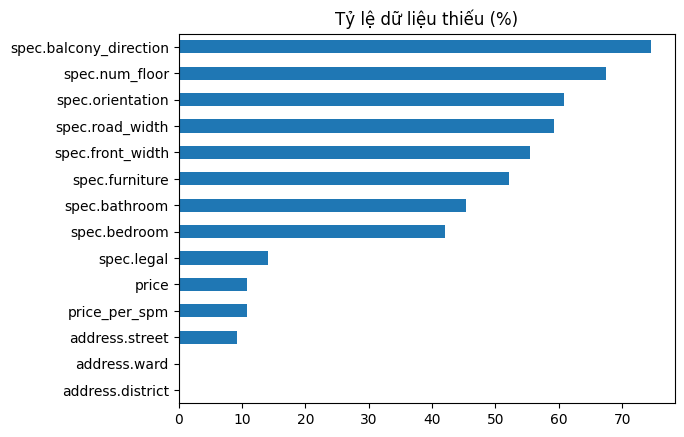

In [29]:
# Kiểm tra dữ liệu thiếu
missing = df.isnull().mean() * 100
missing[missing > 0].sort_values().plot(kind='barh')
plt.title("Tỷ lệ dữ liệu thiếu (%)")
plt.show()

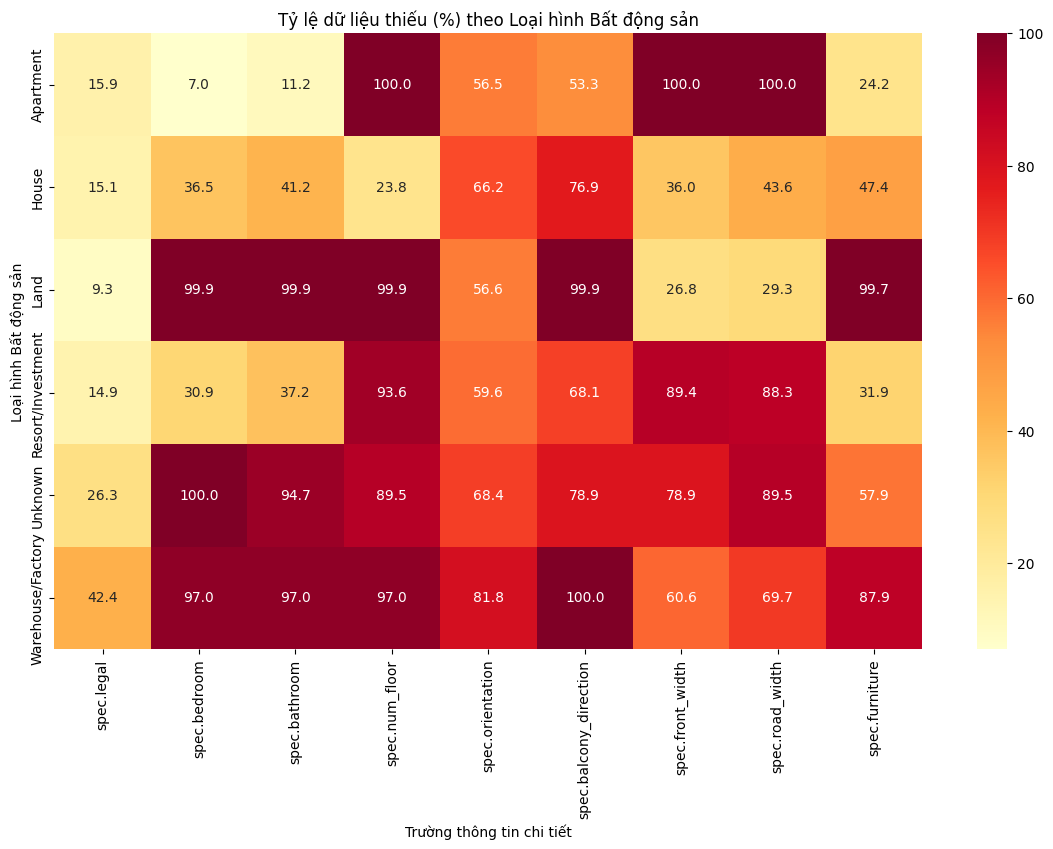

In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Chọn các cột thông số kỹ thuật (thường bị thiếu)
spec_cols = [col for col in df.columns if col.startswith('spec.')]

# Tính tỷ lệ % thiếu cho từng cột, nhóm theo type_property
missing_by_type = df.groupby('type_property')[spec_cols].apply(lambda x: x.isnull().mean() * 100)

# Vẽ Heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(missing_by_type, annot=True, cmap='YlOrRd', fmt=".1f")
plt.title('Tỷ lệ dữ liệu thiếu (%) theo Loại hình Bất động sản')
plt.xlabel('Trường thông tin chi tiết')
plt.ylabel('Loại hình Bất động sản')
plt.show()

📌 Quan sát từ biểu đồ:

Đặc thù theo loại hình: Nhóm "Land" (Đất nền) và "Project Land" có tỷ lệ thiếu gần như 100% ở các trường bedroom, bathroom và num_floor. Điều này phản ánh đúng thực tế vì sản phẩm chưa có công trình xây dựng, không phải lỗi hệ thống.

Nhóm dữ liệu "vàng": Loại hình "Apartment" (Căn hộ) có dữ liệu đầy đủ nhất (tỷ lệ thiếu thấp nhất), đặc biệt là các thông số về công năng sử dụng. Đây là nhóm dữ liệu chất lượng nhất để xây dựng các mô hình dự báo giá.

Điểm yếu chung: Các trường spec.furniture (nội thất) và spec.balcony_direction (hướng ban công) bị thiếu trầm trọng trên tất cả các loại hình (từ 75% đến 95%).

💡 Insight rút ra:

Người đăng tin chỉ tập trung cung cấp các thông tin "sống còn" để bán hàng (Diện tích, Giá, Pháp lý). Các thông tin mang tính chất trải nghiệm (Nội thất, Hướng) thường bị bỏ qua.

Dữ liệu từ website https://www.google.com/search?q=batdongsan.com.vn có sự phân hóa rõ rệt: Tin đăng căn hộ chuyên nghiệp và đầy đủ hơn so với tin đăng đất nền hoặc nhà riêng lẻ.


## Visualization

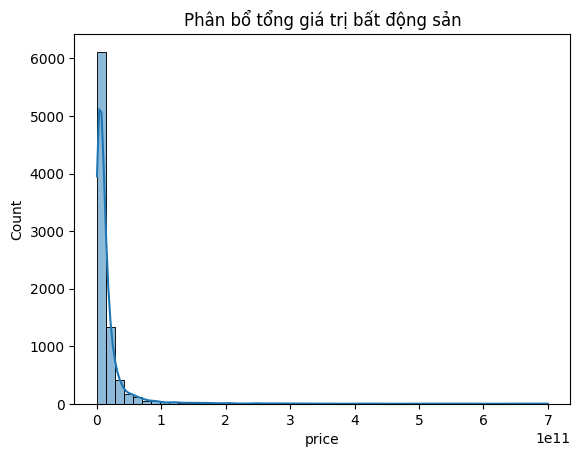

In [30]:
# Phân bổ Giá (Sử dụng thang Log nếu dữ liệu quá lệch)
sns.histplot(df[df['price'] > 0]['price'], bins=50, kde=True)
plt.title("Phân bổ tổng giá trị bất động sản")
plt.show()

Biểu đồ trên thể hiện phân bố tổng giá trị bất động sản (price) trong tập dữ liệu.

- Phân bố có dạng lệch phải rất mạnh (right-skewed), trong đó:

- - Phần lớn bất động sản có mức giá thấp đến trung bình.
- - Chỉ một số ít bất động sản có giá trị rất cao, tạo ra các outlier kéo dài về phía bên phải của phân bố.
- Hiện tượng này phản ánh đúng đặc điểm thực tế của thị trường bất động sản, nơi:

- - Bất động sản phổ thông chiếm đa số.
- - Các bất động sản cao cấp hoặc dự án lớn có giá trị vượt trội nhưng số lượng ít.

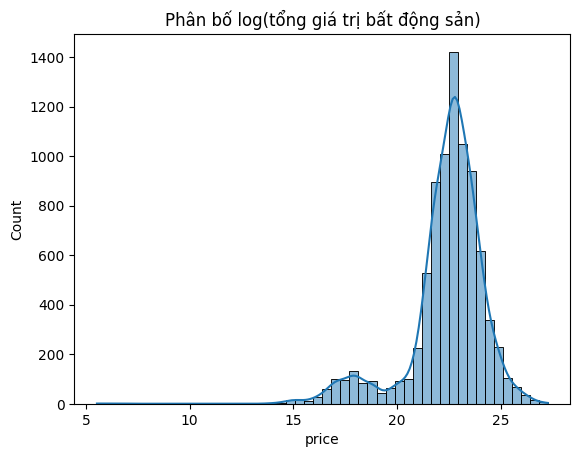

In [44]:
import numpy as np
sns.histplot(np.log1p(df['price']), bins=50, kde=True)
plt.title("Phân bố log(tổng giá trị bất động sản)")
plt.show()


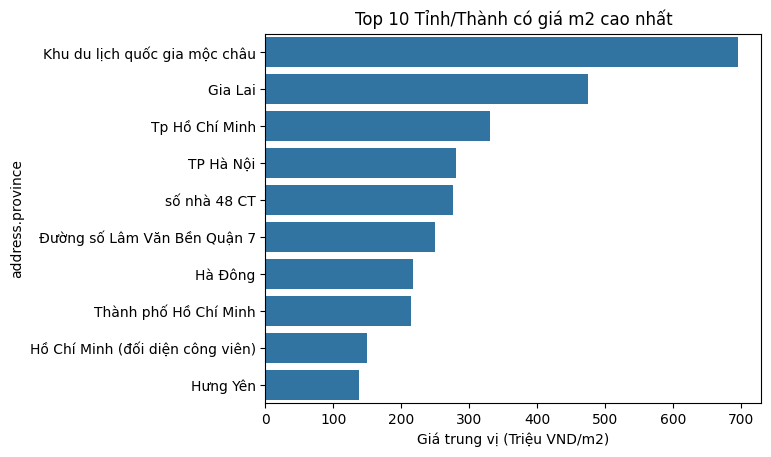

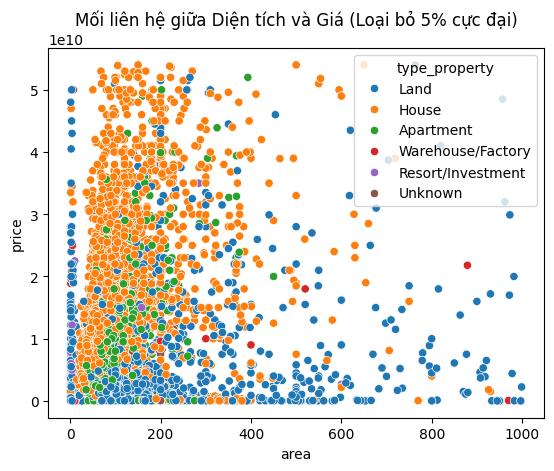

In [31]:
# So sánh giá trung vị mỗi m2 theo Tỉnh thành (Top 10)
top_provinces = df.groupby('address.province')['price_per_spm'].median().sort_values(ascending=False).head(10)
sns.barplot(x=top_provinces.values, y=top_provinces.index)
plt.xlabel("Giá trung vị (Triệu VND/m2)")
plt.title("Top 10 Tỉnh/Thành có giá m2 cao nhất")
plt.show()

# Tương quan giữa Diện tích và Tổng Giá
sns.scatterplot(data=df[df['price'] < df['price'].quantile(0.95)], x='area', y='price', hue='type_property')
plt.title("Mối liên hệ giữa Diện tích và Giá (Loại bỏ 5% cực đại)")
plt.show()

In [32]:

import sys
# !{sys.executable} -m pip install folium
import folium
from folium.plugins import HeatMap

# Tạo bản đồ tập trung tại Việt Nam
m = folium.Map(location=[16.4637, 107.5909], zoom_start=6)

# Loại bỏ dữ liệu thiếu tọa độ
geo_data = df[['latitude', 'longitude']].dropna()

# Thêm lớp Heatmap
HeatMap(data=geo_data[['latitude', 'longitude']], radius=10).add_to(m)

# Lưu bản đồ ra file HTML
# m.save("map_hotspots.html")


C:\Users\Admin\AppData\Local\Temp\ipykernel_19408\3301513362.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df[df['price'] > 0], x='type_property', y='price', palette='Set3')


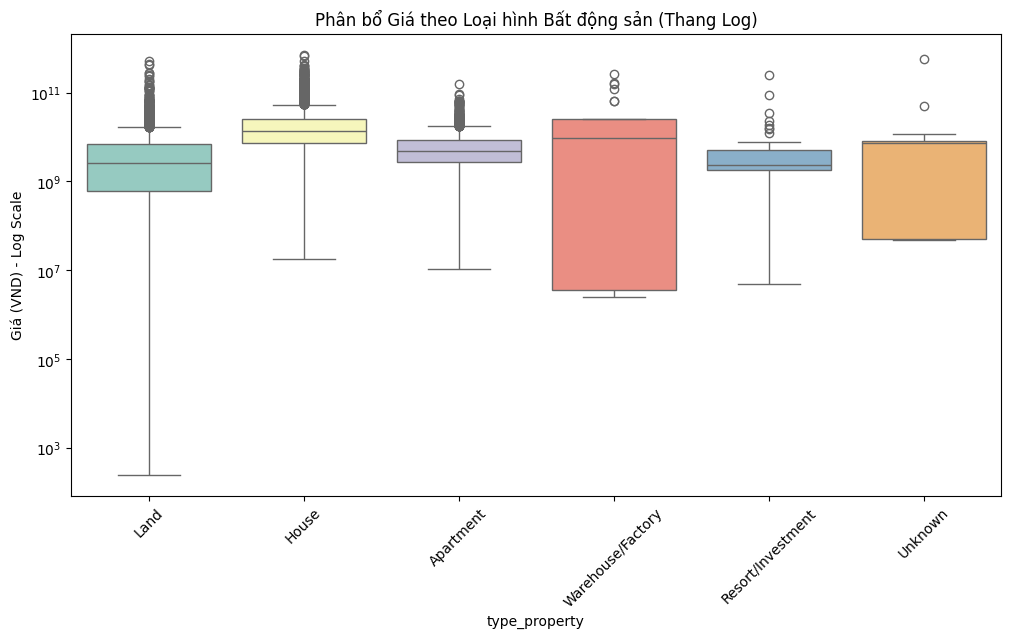

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
# Sử dụng thang log cho trục Y vì giá bất động sản có độ lệch rất lớn
sns.boxplot(data=df[df['price'] > 0], x='type_property', y='price', palette='Set3')
plt.yscale('log') 
plt.title('Phân bổ Giá theo Loại hình Bất động sản (Thang Log)')
plt.xticks(rotation=45)
plt.ylabel('Giá (VND) - Log Scale')
plt.show()

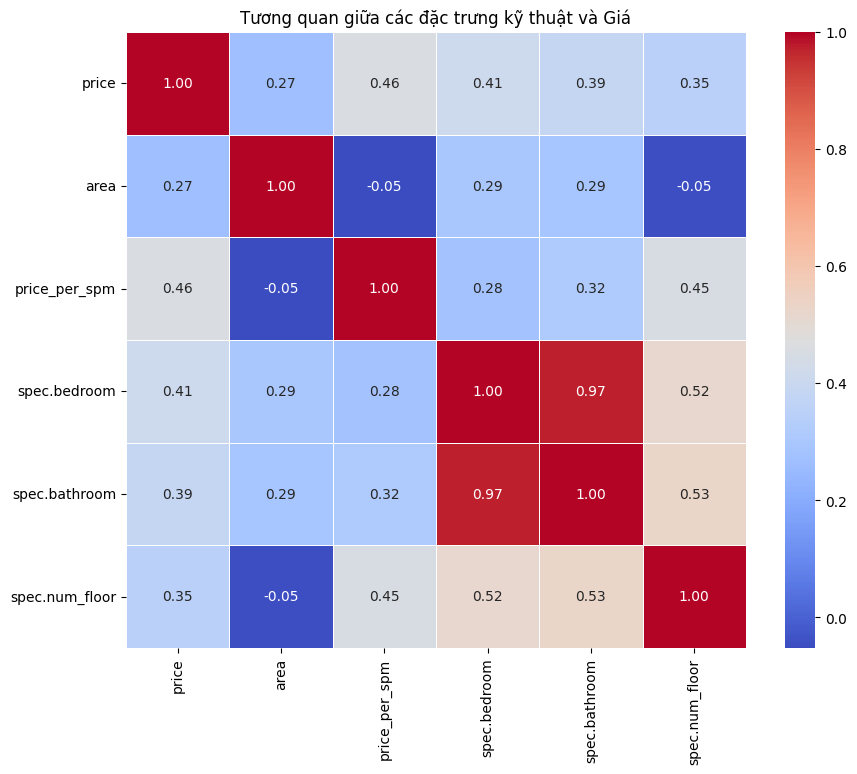

In [37]:
plt.figure(figsize=(10, 8))
# Lọc các cột số
numeric_cols = ['price', 'area', 'price_per_spm', 'spec.bedroom', 'spec.bathroom', 'spec.num_floor']
corr = df[numeric_cols].corr()

sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Tương quan giữa các đặc trưng kỹ thuật và Giá')
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_19408\2503518489.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=district_price.values, y=district_price.index, palette='rocket')


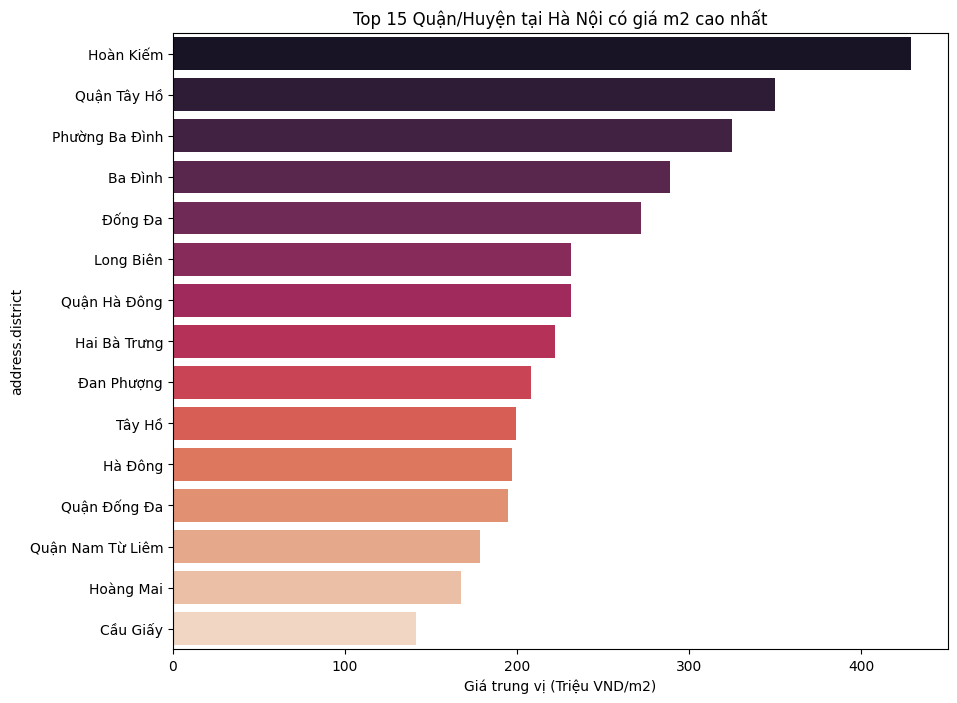

In [38]:
# Lọc dữ liệu Hà Nội
hn_df = df[df['address.province'] == 'Hà Nội'].copy()

# Tính giá trung vị mỗi m2 theo Quận
district_price = hn_df.groupby('address.district')['price_per_spm'].median().sort_values(ascending=False).head(15)

plt.figure(figsize=(10, 8))
sns.barplot(x=district_price.values, y=district_price.index, palette='rocket')
plt.title('Top 15 Quận/Huyện tại Hà Nội có giá m2 cao nhất')
plt.xlabel('Giá trung vị (Triệu VND/m2)')
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_19408\135679007.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=district_price.values, y=district_price.index, palette='rocket')


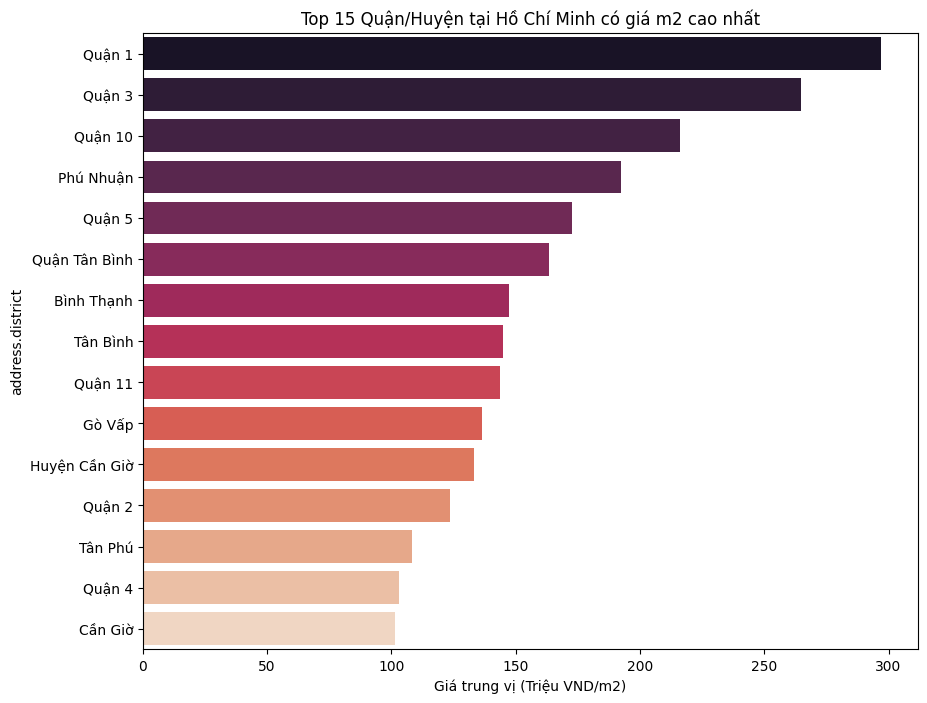

In [39]:
# Lọc dữ liệu Hồ Chí Minh
hn_df = df[df['address.province'] == 'Hồ Chí Minh'].copy()

# Tính giá trung vị mỗi m2 theo Quận
district_price = hn_df.groupby('address.district')['price_per_spm'].median().sort_values(ascending=False).head(15)

plt.figure(figsize=(10, 8))
sns.barplot(x=district_price.values, y=district_price.index, palette='rocket')
plt.title('Top 15 Quận/Huyện tại Hồ Chí Minh có giá m2 cao nhất')
plt.xlabel('Giá trung vị (Triệu VND/m2)')
plt.show()

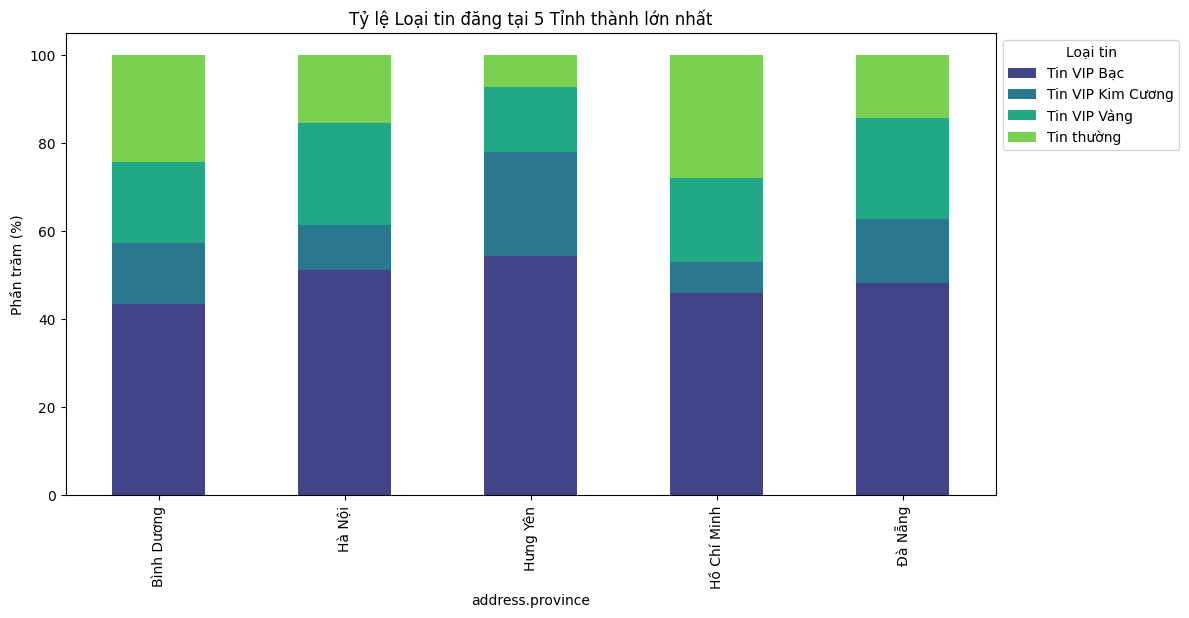

In [40]:
# Lấy top 5 tỉnh có nhiều tin đăng nhất
top_5_prov = df['address.province'].value_counts().head(5).index
df_top_prov = df[df['address.province'].isin(top_5_prov)]

# Tạo bảng chéo tỷ lệ phần trăm
pivot_news = pd.crosstab(df_top_prov['address.province'], df_top_prov['news_type'], normalize='index') * 100

pivot_news.plot(kind='bar', stacked=True, figsize=(12, 6), color=sns.color_palette('viridis', 4))
plt.title('Tỷ lệ Loại tin đăng tại 5 Tỉnh thành lớn nhất')
plt.ylabel('Phần trăm (%)')
plt.legend(title='Loại tin', bbox_to_anchor=(1, 1))
plt.show()

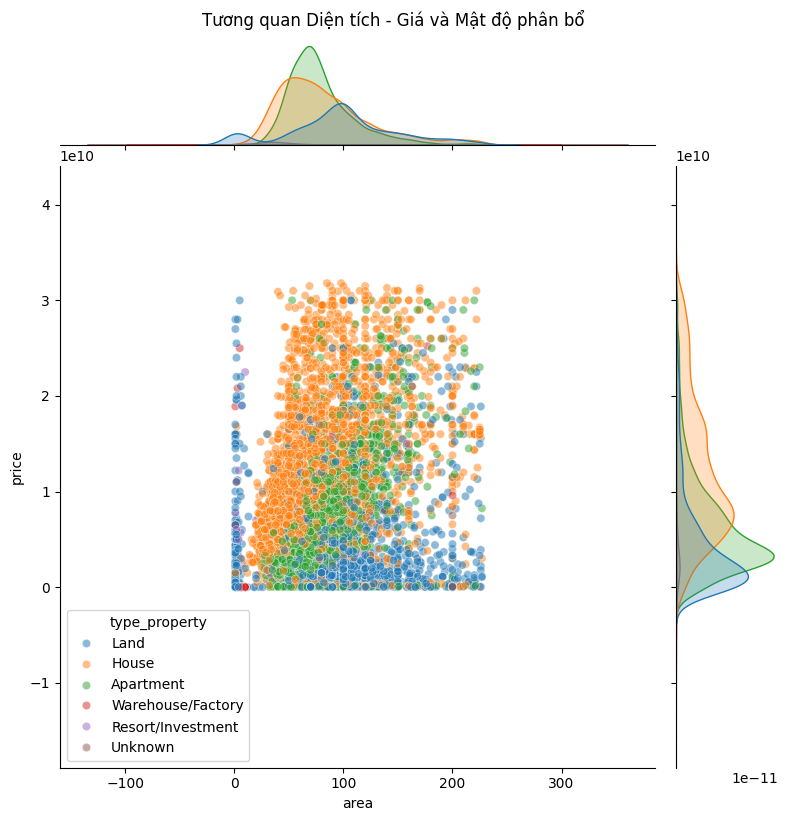

In [41]:
# Loại bỏ 10% các căn hộ có giá/diện tích cao nhất để biểu đồ tập trung vào số đông
plot_data = df[(df['price'] < df['price'].quantile(0.9)) & (df['area'] < df['area'].quantile(0.9))]

g = sns.jointplot(data=plot_data, x='area', y='price', hue='type_property', 
                  alpha=0.5, kind='scatter', height=8)
g.fig.suptitle('Tương quan Diện tích - Giá và Mật độ phân bổ', y=1.02)
plt.show()